In [2]:
# for plotting.. what else
import matplotlib.pyplot as plt

# pull in ODE def & solver
from three_body import three_body_ode, solve

## Example Three Body Computation
We'll find an approximate the solution using the value of $R_0$ below

In [3]:

R0 = np.array([
    [-1.2, -0.80],
    [ 1.0, -0.83],
    [ 1.1,  0.80]
])

sol = solve(R0)
sol


array([[[-1.2       , -0.8       ],
        [ 1.        , -0.83      ],
        [ 1.1       ,  0.8       ]],

       [[-1.19999979, -0.79999996],
        [ 0.99999994, -0.82999983],
        [ 1.09999995,  0.79999977]],

       [[-1.19999917, -0.79999983],
        [ 0.99999974, -0.82999932],
        [ 1.09999978,  0.79999906]],

       ...,

       [[ 0.01779596, -3.96171236],
        [ 0.01973524, -3.96095831],
        [ 1.50673095,  6.61195546]],

       [[ 0.01804623, -3.96136095],
        [ 0.01956476, -3.9614291 ],
        [ 1.50677705,  6.61230022]],

       [[ 0.01848101, -3.96153585],
        [ 0.01929669, -3.9616215 ],
        [ 1.50682315,  6.61264496]]])

We'll now plot the computed trajectories, indicating the initial positions of each body with a red cross symbol.

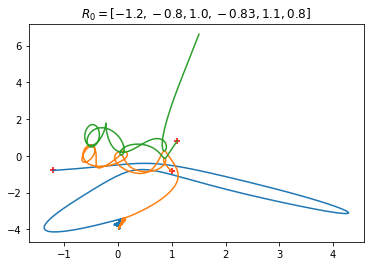

In [4]:

plt.title(f'$R_0 = [{" ,".join(map(str,R0.flatten()))}]$')
for ii in range(3):
    plt.plot(sol[:,ii,0],sol[:,ii,1])
    
plt.scatter(
    sol[0,:,0], sol[0,:,1],
    c='r', marker='+', s=30
)


## Specializing On A Familty of Initial Values
For the purposes of this example, we're interested in collecting information about the behavior of solutions to the three body problem (in 2D) when the initial positions ($r_1$, $r_2$ and $r_3$) are chosen so as to satisfy:
$$
\begin{align}
 r_1 & \sim \mathcal{N}_2\left([-1,-1],\ 0.25\cdot I_2\right) \\
 r_2 & \sim \mathcal{N}_2\left([\ \ \ 1,-1],\ 0.25 \cdot I_2\right) \\
 r_3 & \sim \mathcal{N}_2\left([\ \ \ 1, \ \ \ 1],\ 0.25\cdot I_2\right) \\
\end{align}
$$


Translating this to something tangible, it can be understood as requiring that we only compute solutions with initial values chosen randomly using a function like:

In [5]:

random_position = lambda : np.array([
      [np.random.normal(-1, 0.25), np.random.normal(-1, 0.25)],
      [np.random.normal( 1, 0.25), np.random.normal(-1, 0.25)],
      [np.random.normal( 1, 0.25), np.random.normal( 1, 0.25)]
  ])


However, because of the way pseudo-random numbers are generated by `numpy`; we can't simply put the code from the above cell in `three_body.py` then run it a bunch of times, since this would result in extremely poor sampling/parameter-selection

### Workaround
We have to be deliberate with how we choose and distribute the initial positions. There are several ways we can accomplish this vague task, however in this example we'll only concern ourselves with one.

In this case, what we are going to do is create one very large sample/parameter-list which satisfies the conditions we are looking for, and then use `SLURM` to schedule the computations.

In [6]:
# sample-size/number of parameters
N = 5000

# generating and sorting the sample/parameters
with open('parameters.txt', 'w') as params_file:
    for _ in range(N):
        # observe a random positiion 
        initial_pos = random_position().flatten()
        # store in `params_file` for use later
        print(' '.join(['{:0.5f}']*6).format(*initial_pos), file=params_file)


### Where Job Arrays Come In
We can index the `parameters.txt` using line numbers, and this is fairly standard to do:

In [1]:
!sed -n 2134p "parameters.txt"

-0.74574 -1.21814 0.83396 -1.07720 0.81459 0.85784


What's important about this is that SLURM Job Arrays provide us a sane mechanism we can use to index a collection of jobs.

It does this by making available the `SLURM_ARRAY_TASK_ID` environment variable inside of each executing job for the array. 

In [ ]:

#SBATCH --array 1-1000%25
